# Question A3

Find the optimal number of hidden neurons for first hidden layer of the 4-layer network (3 hidden layers, output layer) designed in Question 1 and 2

#### Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}. Continue using 5-fold cross validation on training dataset. Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

This might take a while to run, approximately 20 - 30 min, so plan your time carefully.

1. Firstly, we import relevant libraries.

In [111]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from common_utils import set_seed

# setting seed
set_seed()

2. To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [112]:
from common_utils import MLP, split_dataset, preprocess_dataset, CustomDataset, loss_fn
import pandas as pd

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        correct += ((pred > 0.5).type(torch.float) == y).type(torch.float).sum().item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    train_loss /= num_batches
    correct /= size
    print(f"Train Error: \n Accuracy: {(correct*100):>0.1f}%, Avg loss: {train_loss:>8f} \n")
    
    return train_loss, correct

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += ((pred > 0.5).type(torch.float) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return test_loss, correct

def preprocess(df):
    
    X_train, y_train, X_test, y_test = split_dataset(df,['filename','label'],0.3,0)
    X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

    return X_train_scaled, y_train, X_test_scaled, y_test

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

X_train_scaled, y_train, X_test_scaled, y_test = preprocess(df)

train_data = CustomDataset(X_train_scaled, y_train)
test_data = CustomDataset(X_test_scaled, y_test)


3. Perform hyperparameter tuning for the different neurons with 5-fold cross validation.

In [113]:
from common_utils import EarlyStopper

def train(model, X_train_scaled, y_train2, X_val_scaled, y_val2, batch_size):

    # YOUR CODE HERE

    train_data = CustomDataset(X_train_scaled, y_train2)
    val_data = CustomDataset(X_val_scaled, y_val2)

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    early_stopper = EarlyStopper(patience=3, min_delta=0)

    train_accuracies = []
    train_losses = []
    test_accuracies = []
    test_losses = []

    times = []
    
    for t in range(100):
        model.train()

        print(f"Epoch {t+1}\n-------------------------------")
        start = time.time()
        
        # Training Loop
        train_loss, train_acc = train_loop(train_dataloader, model, loss_fn, optimizer)
        train_losses.append(train_loss), train_accuracies.append(train_acc)

        end = time.time()
        times.append(end-start)

        # Validation Loop
        test_loss, test_acc = test_loop(val_dataloader, model, loss_fn)
        test_accuracies.append(test_acc), test_losses.append(test_loss)

        if early_stopper.early_stop(test_loss):
            print("Early stopping")
            break

    return train_accuracies, train_losses, test_accuracies, test_losses, times

In [114]:
from common_utils import MLP

def find_optimal_hyperparameter(X_train, y_train, parameters, mode, batch_size):

    # YOUR CODE HERE

    kf = KFold(n_splits=5, shuffle=True, random_state=0)

    cross_validation_accuracies = []
    cross_validation_times = []

    for parameter in parameters:
        print(f"Number of Hidden Nuerons {parameter}\n-------------------------------")
        accuracies = []
        times = []
        
        for train_index, val_index in kf.split(X_train):
            X_train2, X_val2 = X_train[train_index], X_train[val_index]
            y_train2, y_val2 = y_train[train_index], y_train[val_index]
            
            model = MLP(77,parameter,1)

            train_accuracies, train_losses, test_accuracies, test_losses, time = train(model, X_train2, y_train2, X_val2, y_val2, batch_size)
            accuracies.append(test_accuracies[-1])
            times.append(time[-1])
            
        cross_validation_accuracies.append(np.mean(accuracies))
        cross_validation_times.append(np.mean(times))

    return cross_validation_accuracies, cross_validation_times

'''
optimal_bs = 256. Fill your optimal batch size in the following code.
'''
# YOUR CODE HERE
optimal_bs = 128
num_neurons = [64,128,256]
cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train_scaled, y_train, num_neurons, 'num_neurons', optimal_bs)

Number of Hidden Nuerons 64
-------------------------------
Epoch 1
-------------------------------
loss: 0.692401  [  128/ 6751]
Train Error: 
 Accuracy: 53.1%, Avg loss: 0.689013 

Test Error: 
 Accuracy: 56.8%, Avg loss: 0.679435 

Epoch 2
-------------------------------
loss: 0.678510  [  128/ 6751]
Train Error: 
 Accuracy: 57.0%, Avg loss: 0.678092 

Test Error: 
 Accuracy: 58.1%, Avg loss: 0.672666 

Epoch 3
-------------------------------
loss: 0.661662  [  128/ 6751]
Train Error: 
 Accuracy: 59.3%, Avg loss: 0.667083 

Test Error: 
 Accuracy: 59.9%, Avg loss: 0.663261 

Epoch 4
-------------------------------
loss: 0.638613  [  128/ 6751]
Train Error: 
 Accuracy: 61.1%, Avg loss: 0.655486 

Test Error: 
 Accuracy: 61.0%, Avg loss: 0.658421 

Epoch 5
-------------------------------
loss: 0.624810  [  128/ 6751]
Train Error: 
 Accuracy: 62.8%, Avg loss: 0.643882 

Test Error: 
 Accuracy: 63.9%, Avg loss: 0.640438 

Epoch 6
-------------------------------
loss: 0.648848  [  128/ 6

4. Plot the cross-validation accuracies against the number of epochs for different numbers of hidden-layer neurons. Limit the search space of the number of neurons to {64, 128, 256}.

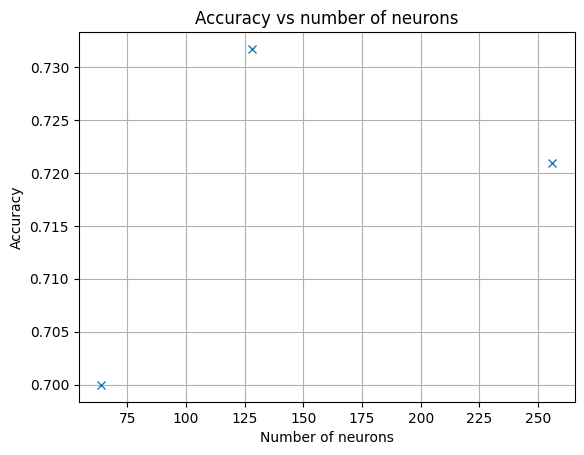

In [115]:
# YOUR CODE HERE

plt.plot(num_neurons, cross_validation_accuracies, marker='x', linestyle='None')
plt.xlabel('Number of neurons')
plt.ylabel('Accuracy')
plt.title('Accuracy vs number of neurons')
plt.grid(True)
plt.show()

5. Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

In [116]:
optimal_neurons = 128
reason = ""
# YOUR CODE HERE

6. Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot.

In [117]:
from common_utils import EarlyStopper

def train_final(model, X_train_scaled, y_train2, X_val_scaled, y_val2, batch_size):

    # YOUR CODE HERE

    train_data = CustomDataset(X_train_scaled, y_train2)
    val_data = CustomDataset(X_val_scaled, y_val2)

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    early_stopper = EarlyStopper(patience=3, min_delta=0)

    train_accuracies = []
    train_losses = []
    test_accuracies = []
    test_losses = []

    times = []

    for t in range(100):
        print(f"Epoch {t+1}\n-------------------------------")
        start = time.time()
        # Training Loop
        model.train()
        train_loss, train_acc = train_loop(train_dataloader, model, loss_fn, optimizer)
        train_losses.append(train_loss), train_accuracies.append(train_acc)
        end = time.time()
        times.append(end-start)

        # Validation Loop
        model.eval()
        test_loss, test_acc = test_loop(val_dataloader, model, loss_fn)
        test_accuracies.append(test_acc), test_losses.append(test_loss)

        if early_stopper.early_stop(test_loss):
            print("Early stopping")
            break

    return train_accuracies, train_losses, test_accuracies, test_losses, times


final_model = MLP(77,optimal_neurons,1)
optimal_bs = 128

train_accuracies, train_losses, test_accuracies, test_losses, times = train_final(final_model, X_train_scaled, y_train, X_test_scaled, y_test, optimal_bs)

# save the model
torch.save(final_model.state_dict(), 'model.pt')

Epoch 1
-------------------------------
loss: 0.701655  [  128/ 8439]
Train Error: 
 Accuracy: 55.2%, Avg loss: 0.684544 

Test Error: 
 Accuracy: 58.5%, Avg loss: 0.672361 

Epoch 2
-------------------------------
loss: 0.664824  [  128/ 8439]
Train Error: 
 Accuracy: 59.5%, Avg loss: 0.665055 

Test Error: 
 Accuracy: 59.1%, Avg loss: 0.662086 

Epoch 3
-------------------------------
loss: 0.658269  [  128/ 8439]
Train Error: 
 Accuracy: 62.0%, Avg loss: 0.645948 

Test Error: 
 Accuracy: 61.8%, Avg loss: 0.656400 

Epoch 4
-------------------------------
loss: 0.619425  [  128/ 8439]
Train Error: 
 Accuracy: 64.5%, Avg loss: 0.625845 

Test Error: 
 Accuracy: 63.7%, Avg loss: 0.631308 

Epoch 5
-------------------------------
loss: 0.605404  [  128/ 8439]
Train Error: 
 Accuracy: 67.0%, Avg loss: 0.604004 

Test Error: 
 Accuracy: 65.2%, Avg loss: 0.624979 

Epoch 6
-------------------------------
loss: 0.560920  [  128/ 8439]
Train Error: 
 Accuracy: 69.1%, Avg loss: 0.581758 

Te

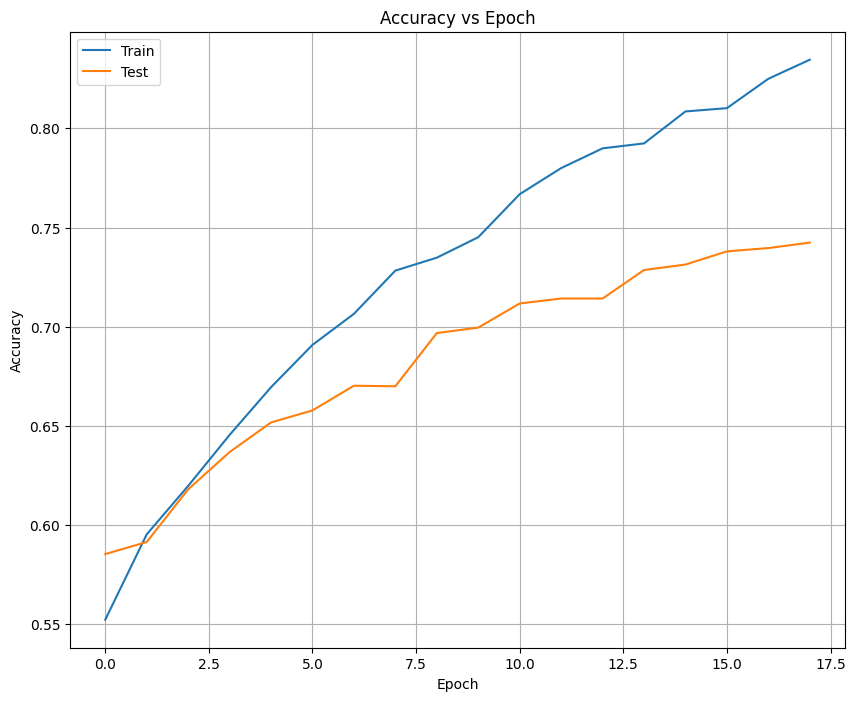

In [118]:
# YOUR CODE HERE
plt.figure(figsize=(10,8))
plt.plot(train_accuracies, label='Train')
plt.plot(test_accuracies, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.grid(True)
plt.legend()